In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob

import matplotlib.colors as mcolors

from netCDF4 import Dataset
from scipy import stats

from wrf import getvar

from matplotlib.animation import FuncAnimation


## estimate of pressure levels from the hybrid coordinate:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100

### First, load the lats, lons, and levs used for plotting later.

In [3]:
### Plot the height vs. time sections of potential temperature
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILdeforested/wrfout_d01_2015-11-01_00:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lats=ds1['XLAT'][0,:,0]
    lons=ds1['XLONG'][0,0,:]
    lu1=ds1['LU_INDEX'][0,:,:]
    pb = ds1['PB'][0,:,:,:]

## Check whether LUindex is changed correctly

[Text(1, 5.0, 'forests'),
 Text(1, 7.0, 'shrublands'),
 Text(1, 9.0, 'savannas'),
 Text(1, 12.0, 'cropland'),
 Text(1, 16.0, 'water')]

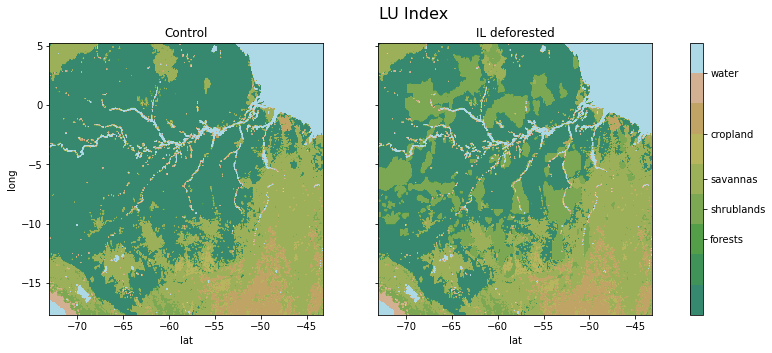

In [4]:
file0 = path+'Amazon561x721/energyflux_d01_2015-11-30_22:00:00'
with xarray.open_dataset(file0,decode_times=False,
                         mask_and_scale='True') as ds0:
    lu0=ds0['LU_INDEX'][0,:,:]

file1 = path+'Amazon561x721_ILgrassland/energyflux_d01_2015-11-30_22:00:00'
with xarray.open_dataset(file1,decode_times=False,
                         mask_and_scale='True') as ds1:
    lu1=ds1['LU_INDEX'][0,:,:]

### generate a new cmap
cmap = plt.get_cmap('gist_earth')
colors = cmap(np.linspace(0.3, 0.89, 100))
new_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)
new_cmap.set_over('lightblue')
############

fig,axes = plt.subplots(1,2,figsize=(13.5,5),sharex=True,sharey=True)
axes = axes.ravel()  
im=axes[0].contourf(lons,lats,lu0,cmap=new_cmap,vmax=16)  # ctrl luindex
axes[1].contourf(lons,lats,lu1,cmap=new_cmap,vmax=16)     # ILdeforeste luindex
axes[0].set_title('Control')
axes[1].set_title('IL deforested')
axes[0].set_xlabel('lat')
axes[1].set_xlabel('lat')
axes[0].set_ylabel('long')
plt.suptitle('LU Index',fontsize=16)
cbar = fig.colorbar(im,ax=axes, ticks = [5,7,9,12,16])
cbar.ax.set_yticklabels(['forests', 'shrublands', 'savannas','cropland','water'])  # vertically oriented colorbar

# 1. 2D fields

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

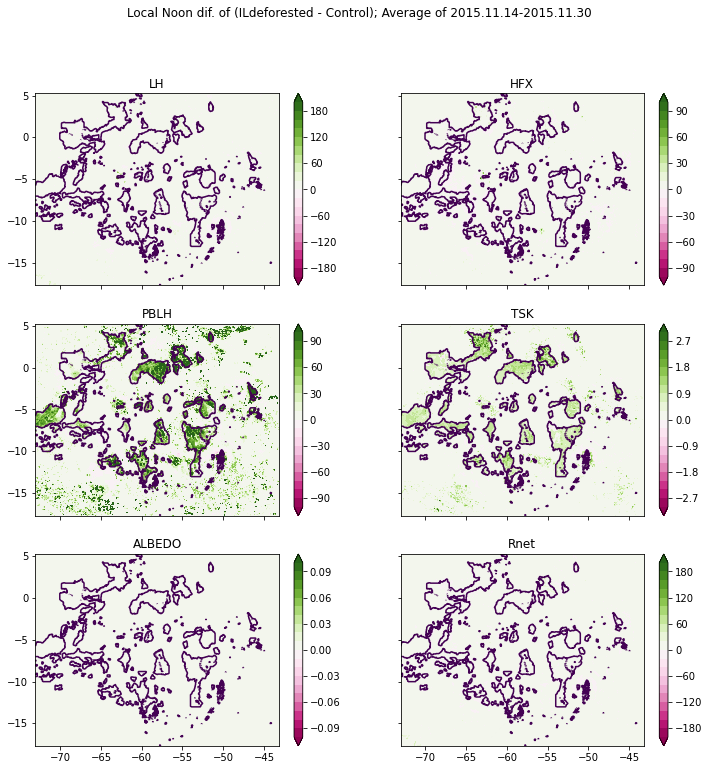

In [36]:
TIME=0 ### Select local noon
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
#file = path+'post_processing/Amazon561x721/energy.2015.ILgrassland.multidaymean.nc'
#with xarray.open_dataset(path+'Amazon561x721/energyflux_d01_2015-11-01_15:00:00',decode_times=False,

with xarray.open_dataset(path+'Amazon561x721/energyflux_d01_2015-11-01_05:00:00',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

#with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
 #                        mask_and_scale='True') as ds0:
with xarray.open_dataset(path+'Amazon561x721_ILgrassland/energyflux_d01_2015-11-01_05:00:00',decode_times=False,
                         mask_and_scale='True') as ds1:
                         print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','PBLH','TSK','ALBEDO']
levs = [np.arange(-200,201,20),np.arange(-100,101,10),np.arange(-100,101,10),np.arange(-3,3.1,0.3),
        np.arange(-0.1,0.11,0.01)]
for ii in range(5):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][TIME,:,:]-ds0[varname[ii]][TIME,:,:],cmap='PiYG',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].contourf(lons,lats,Rnet1[TIME,:,:]-Rnet0[TIME,:,:],
                       levels = np.arange(-200,201,20),extend='both',cmap='PiYG')
fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

## 1.1 Diurnal cycle of these 2D fields

In [ ]:
## Plot T2m
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/T2.201511.ILgrassland.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_T2:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/T2.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0_T2:
    print('ok')
tmp = ds1_T2[varname[4]][:,:,:]-ds0_T2[varname[4]][:,:,:]
var_IL = tmp.where(dif_lu>0,np.nan)
var_IL_areaave = var_IL.mean(('south_north','west_east'))
T2_IL_areaave = np.reshape(var_IL_areaave[14*24:].values,(16,24)).mean(axis=0)


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

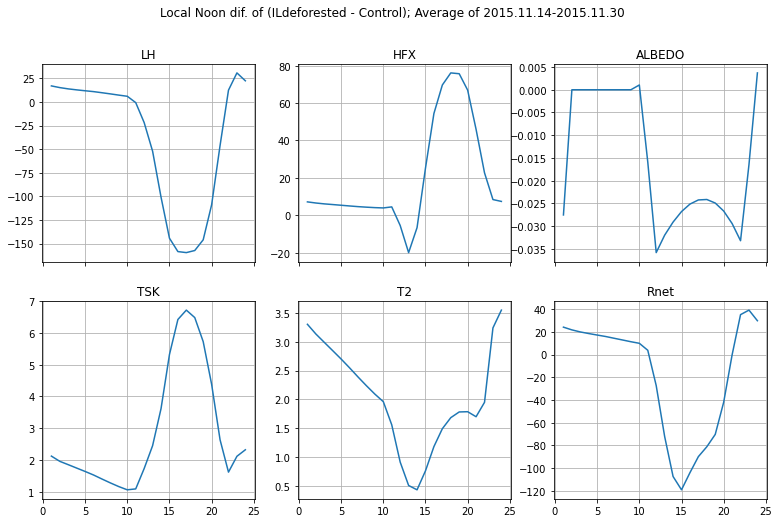

In [23]:
fig,axes = plt.subplots(2,3,figsize=(13,8),sharex=True)
axes = axes.ravel()  
varname = ['LH','HFX','ALBEDO','TSK','T2']

dif_lu = lu1-lu0

for ii in range(4):
    var = ds1[varname[ii]][:,:,:]-ds0[varname[ii]][:,:,:]
    var_IL = var.where(dif_lu>0,np.nan)
    #var_out = var.where(dif_lu==0,np.nan)
    var_IL_areaave = var_IL.mean(('south_north','west_east'))
    #var_out_areaave = var_out.mean(('south_north','west_east'))
    #print(var_IL_areaave)
    axes[ii].plot(np.arange(1,25),var_IL_areaave)
    axes[ii].grid()
    axes[ii].set_title(varname[ii])

## Plot T2m
axes[4].plot(np.arange(1,25),T2_IL_areaave)
axes[4].grid()
axes[4].set_title('T2')

## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']
dif_Rnet = Rnet1 - Rnet0
var_IL = dif_Rnet.where(dif_lu>0,np.nan)
var_IL_areaave = var_IL.mean(('south_north','west_east'))
axes[5].plot(np.arange(1,25),var_IL_areaave)
axes[5].grid()
axes[5].set_title('Rnet')
    
plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

# T2 and TSK are just the opposite. How is TSK calculated?

# 2. Potential temperature

### 2.1 Height-time cross section of the area-mean, inside and outside of the deforested Indigenous lands.

Text(0, 0.5, 'Outside of IL')

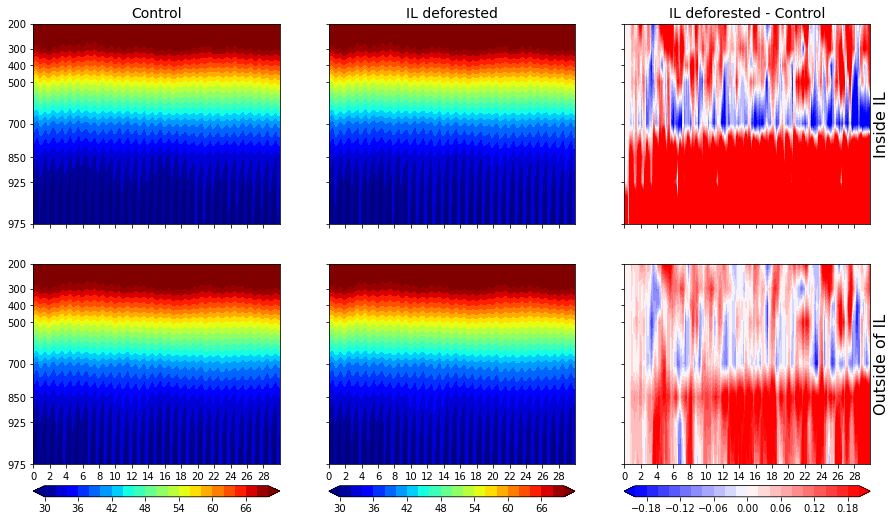

In [10]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/Theta_IL_areaave.obs.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_IL:
    theta0_IL_areaave = ds0_IL['T']+300-273.15
with xarray.open_dataset(path+'post_processing/Amazon561x721/Theta_out_areaave.obs.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds0_out:
    theta0_out_areaave = ds0_out['T']+300-273.15
with xarray.open_dataset(path+'post_processing/Amazon561x721/Theta_IL_areaave.ILgrassland.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_IL:
    theta1_IL_areaave = ds1_IL['T']+300-273.15
with xarray.open_dataset(path+'post_processing/Amazon561x721/Theta_out_areaave.ILgrassland.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_out:
    theta1_out_areaave = ds1_out['T']+300-273.15
    
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100
levs=[0,5,8,12,17,19,21,24]
pres=[975,925,850,700,500,400,300,200]
fig,axes = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
axes=axes.ravel()
im0=axes[0].contourf(np.arange(0,720),levs,theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im=axes[1].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose(),
             levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im=axes[2].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-0.2,0.21,0.02),
            extend='both',cmap='bwr')

im=axes[3].contourf(np.arange(0,720),levs,theta0_out_areaave[:,levs].transpose(),
             levels=np.arange(30,71,2),
            extend='both',cmap='jet')
im=axes[4].contourf(np.arange(0,720),levs,theta1_out_areaave[:,levs].transpose(),
             levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im_dif=axes[5].contourf(np.arange(0,720),levs,theta1_out_areaave[:,levs].transpose()-theta0_out_areaave[:,levs].transpose(),
             levels=np.arange(-0.2,0.21,0.02),
            extend='both',cmap='bwr')

fig.colorbar(im0,ax=axes[[0,3]],orientation='horizontal',pad=0.04)
fig.colorbar(im0,ax=axes[[1,4]],orientation='horizontal',pad=0.04)
fig.colorbar(im_dif,ax=axes[[2,5]],orientation='horizontal',pad=0.04)

for ii in [0,3]:
    axes[ii].set_yticks(levs)
    axes[ii].set_yticklabels(pres)

#axes.set_ylim([0,24])
for ii in range(3,6):
    axes[ii].set_xticks(np.arange(0,720,48))
    axes[ii].set_xticklabels(np.arange(0,30,2))

axes[0].set_title('Control',fontsize=14)
axes[1].set_title('IL deforested',fontsize=14)
axes[2].set_title('IL deforested - Control',fontsize=14)

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel('Inside IL',fontsize=16)

axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel('Outside of IL',fontsize=16)

### It seems that there is a strong diurnal cycle in Theta. Let's zoom it up and take a look of the average of the diurnal cycle

Text(0, 0.5, 'Pressure [hPa]')

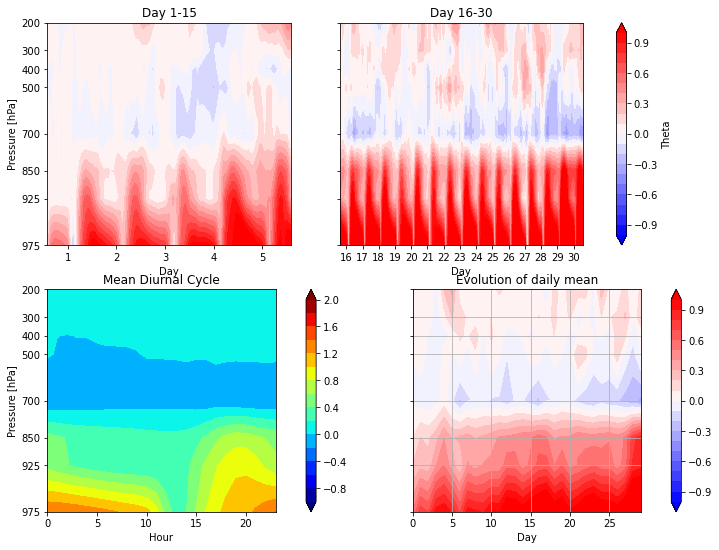

In [14]:
dif_theta = theta1_IL_areaave - theta0_IL_areaave
dif_theta_diurnal = np.reshape(dif_theta.values,(30,24,34)).mean(axis=0)
dif_theta_diurnal.shape

dif_theta_daily = np.reshape(dif_theta.values,(30,24,34)).mean(axis=1)

fig,axes = plt.subplots(2,2,figsize=(12,9),sharey=True)
axes=axes.ravel()
axes[0].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
axes[0].set_xlim([0,5*24])

im=axes[1].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
axes[1].set_xlim([15*24,720])
fig.colorbar(im,ax=axes[:2],orientation='vertical',pad=0.05,label='Theta')

im2=axes[2].contourf(np.arange(0,24),levs,dif_theta_diurnal[:,levs].transpose(),
             levels=np.arange(-1.0,2.1,0.2),
            extend='both',cmap='jet')
fig.colorbar(im2,ax=axes[2],orientation='vertical',pad=0.1)

im2=axes[3].contourf(np.arange(0,30),levs,dif_theta_daily[:,levs].transpose(),
                    levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
fig.colorbar(im2,ax=axes[3],orientation='vertical',pad=0.1)


titles=['Day 1-15','Day 16-30','Mean Diurnal Cycle','Evolution of daily mean']
for ii in range(4):
    axes[ii].set_title(titles[ii])

axes[0].set_yticks(levs)
axes[0].set_yticklabels(pres)
axes[3].grid()

#for ii in range(2):
axes[0].set_xticks(np.arange(0+10,5*24+10,24))
axes[0].set_xticklabels(np.arange(1,6))
axes[1].set_xticks(np.arange(15*24+10,30*24+10,24))
axes[1].set_xticklabels(np.arange(16,31))
    
xlabels=['Day','Day','Hour','Day']
for ii in range(4):
    axes[ii].set_xlabel(xlabels[ii])

axes[0].set_ylabel('Pressure [hPa]')
axes[2].set_ylabel('Pressure [hPa]')

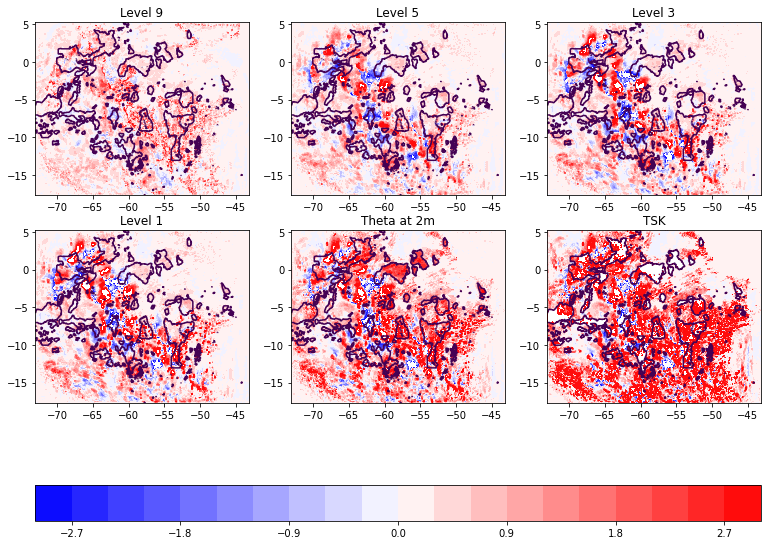

In [16]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'

## Potential Temp at 2m
with xarray.open_dataset(path+'Amazon561x721/3Dfields_d01_2015-11-02_15:00:00',decode_times=False,
                         mask_and_scale='True') as ds00_T:
    TH2m0 = ds00_T['TH2'][0,:,:]

with xarray.open_dataset(path+'Amazon561x721_ILgrassland/3Dfields_d01_2015-11-02_15:00:00',decode_times=False,
                         mask_and_scale='True') as ds11_T:
    TH2m1 = ds11_T['TH2'][0,:,:]

## TSK
with xarray.open_dataset(path+'Amazon561x721/energyflux_d01_2015-11-02_15:00:00',decode_times=False,
                         mask_and_scale='True') as ds00:
    TSK0 = ds00['TSK'][0,:,:]

with xarray.open_dataset(path+'Amazon561x721_ILgrassland/energyflux_d01_2015-11-02_15:00:00',decode_times=False,
                         mask_and_scale='True') as ds11:
    TSK1 = ds11['TSK'][0,:,:]
    
### Plot figure
fig,axes= plt.subplots(2,3,figsize=(13,10))
axes=axes.ravel()
levs=[9,5,3,1,0]

for ii in range(4):
    im0=axes[ii].contourf(lons,lats,ds11_T['THM'][0,levs[ii],:,:]-ds00_T['THM'][0,levs[ii],:,:],cmap='bwr',
                     levels=np.arange(-3,3.1,0.3)
                    )
for ii in range(4):
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    axes[ii].set_title('Level '+str(levs[ii]))

## Plot Potential Temp at 2m. 
axes[4].contourf(lons,lats,TH2m1-TH2m0,cmap='bwr',
                levels=np.arange(-3,3.1,0.3))
axes[4].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[4].set_title('Theta at 2m')

## Plot Potential Temp at 2m. 
axes[5].contourf(lons,lats,TSK1-TSK0,cmap='bwr',
                levels=np.arange(-3,3.1,0.3))
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[5].set_title('TSK')
    
fig.colorbar(im0,ax=axes[:6],orientation='horizontal')

# Precipitation

ok
ok


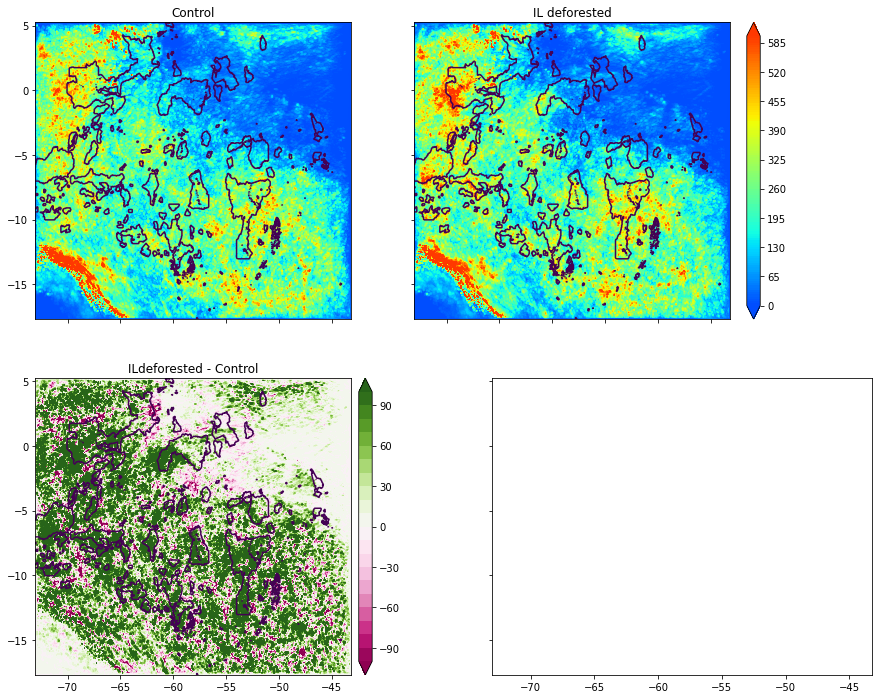

In [5]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILgrassland/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_rain:
    print('ok')

file = path+'Amazon561x721/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_rain:
    print('ok')

### plot the figure
fig,axes = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
axes = axes.ravel()  

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.2, 0.85, 100))
newjet_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)

img=axes[0].contourf(lons,lats,ds0_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                    extend='both')
axes[1].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                extend='both')
axes[1].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[0].contour(lons,lats,lu1-lu0,levels=[1,10])

fig.colorbar(img, ax=axes[0:2],location='right',pad=0.02)
axes[0].set_title('Control')
axes[1].set_title('IL deforested')

img2=axes[2].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:]-ds0_rain['RAINNC'][0,:,:],
                      levels = np.arange(-100,101,10),cmap='PiYG',extend='both')
fig.colorbar(img2, ax=axes[2],location='right',pad=0.02)
axes[2].set_title('ILdeforested - Control')
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])


ok
ok


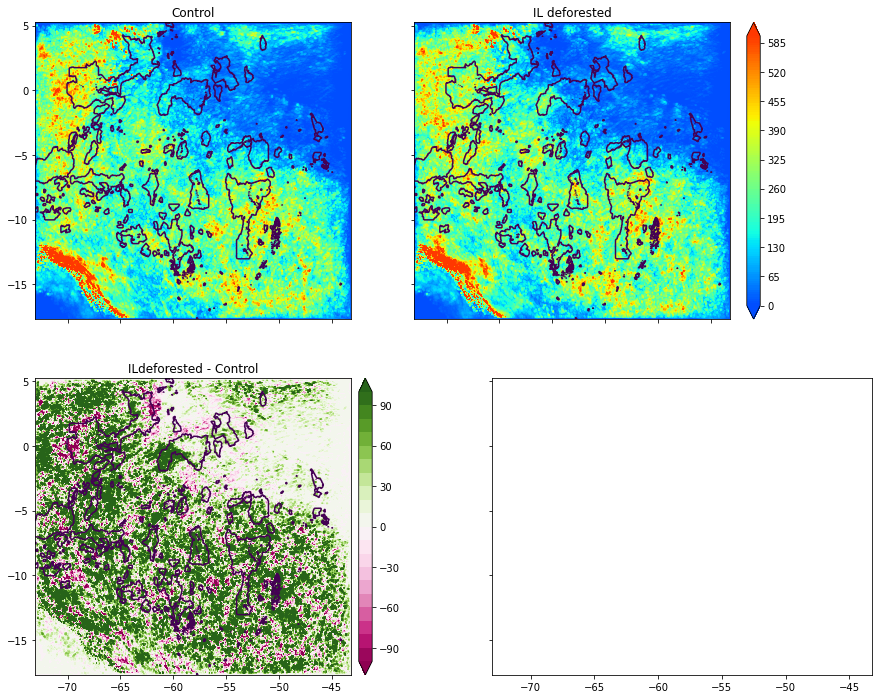

In [6]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILdeforested/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_rain:
    print('ok')

file = path+'Amazon561x721/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_rain:
    print('ok')

### plot the figure
fig,axes = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
axes = axes.ravel()  

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.2, 0.85, 100))
newjet_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)

img=axes[0].contourf(lons,lats,ds0_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                    extend='both')
axes[1].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                extend='both')
axes[1].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[0].contour(lons,lats,lu1-lu0,levels=[1,10])

fig.colorbar(img, ax=axes[0:2],location='right',pad=0.02)
axes[0].set_title('Control')
axes[1].set_title('IL deforested')

img2=axes[2].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:]-ds0_rain['RAINNC'][0,:,:],
                      levels = np.arange(-100,101,10),cmap='PiYG',extend='both')
fig.colorbar(img2, ax=axes[2],location='right',pad=0.02)
axes[2].set_title('ILdeforested - Control')
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])


### TSK

ok
ok


Text(0.5, 1.0, 'UTC 9')

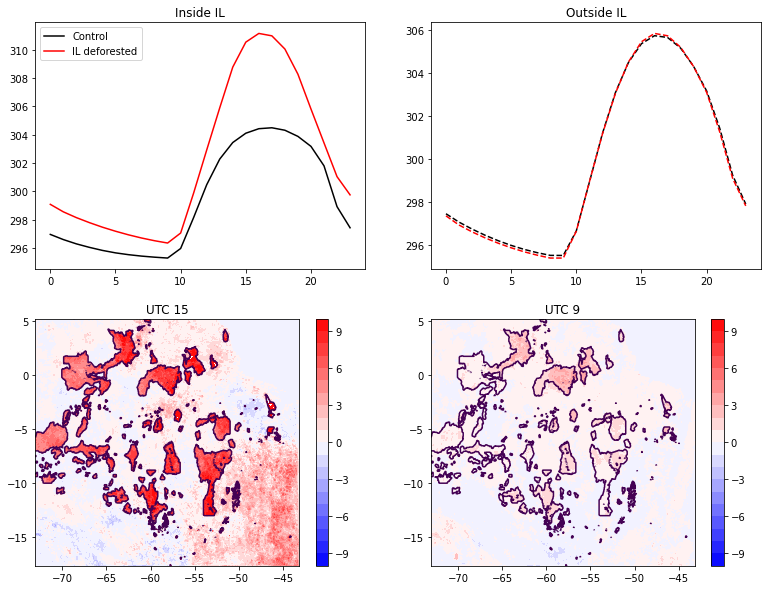

In [24]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.2015.ILgrassland.multidaymean.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

dif_lu = lu1 - lu0
TSK0_IL = ds0['TSK'].where(dif_lu>0,np.nan).mean(('south_north','west_east'))
TSK0_out = ds0['TSK'].where(dif_lu==0,np.nan).mean(('south_north','west_east'))
TSK1_IL = ds1['TSK'].where(dif_lu>0,np.nan).mean(('south_north','west_east'))
TSK1_out = ds1['TSK'].where(dif_lu==0,np.nan).mean(('south_north','west_east'))
    
fig,axes= plt.subplots(2,2,figsize=(13,10))
axes=axes.ravel()
axes[0].plot(TSK0_IL,'-k',label='Control')
axes[0].plot(TSK1_IL,'-r',label='IL deforested')
axes[1].plot(TSK0_out,'--k')
axes[1].plot(TSK1_out,'--r')
axes[0].set_title('Inside IL')
axes[1].set_title('Outside IL')
axes[0].legend()
im0=axes[2].contourf(lons,lats,ds1['TSK'][15,:,:]-ds0['TSK'][15,:,:],cmap='bwr',levels=np.arange(-10,11,1))
im1=axes[3].contourf(lons,lats,ds1['TSK'][9,:,:]-ds0['TSK'][9,:,:],cmap='bwr',levels=np.arange(-10,11,1))
fig.colorbar(im0,ax=axes[2])
fig.colorbar(im1,ax=axes[3])
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[3].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[2].set_title('UTC 15')
axes[3].set_title('UTC 9')


# 2. Energy

In [25]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.2015.ILgrassland.day1_5.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.2015.obs.day1_5.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
varname = ['SWUPT','SWDNT','SWUPB','SWDNB','SWDNBC','LWUPT','LWUPTC','LWUPB','LWUPBC','LWDNB','LWDNBC']
dif_lu = lu1-lu0
for ii in range(11):
    var0 = ds0[varname[ii]]
    var1 = ds1[varname[ii]]
    var0_IL_name = varname[ii]+'0_IL'
    var0_out_name = varname[ii]+'0_out'
    var1_IL_name = varname[ii]+'1_IL'
    var1_out_name = varname[ii]+'1_out'
    globals()[var0_IL_name] = var0.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
    globals()[var0_out_name] = var0.where(dif_lu==0,np.nan).mean(('south_north','west_east'))
    globals()[var1_IL_name] = var1.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
    globals()[var1_out_name] = var1.where(dif_lu==0,np.nan).mean(('south_north','west_east'))

ok
ok


In [26]:
varname = ['LH','HFX']
for ii in range(2):
    var0 = ds0[varname[ii]]
    var1 = ds1[varname[ii]]
    var0_IL_name = varname[ii]+'0_IL'
    var0_out_name = varname[ii]+'0_out'
    var1_IL_name = varname[ii]+'1_IL'
    var1_out_name = varname[ii]+'1_out'
    globals()[var0_IL_name] = var0.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
    globals()[var0_out_name] = var0.where(dif_lu==0,np.nan).mean(('south_north','west_east'))
    globals()[var1_IL_name] = var1.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
    globals()[var1_out_name] = var1.where(dif_lu==0,np.nan).mean(('south_north','west_east'))

(380.0, 420.0)

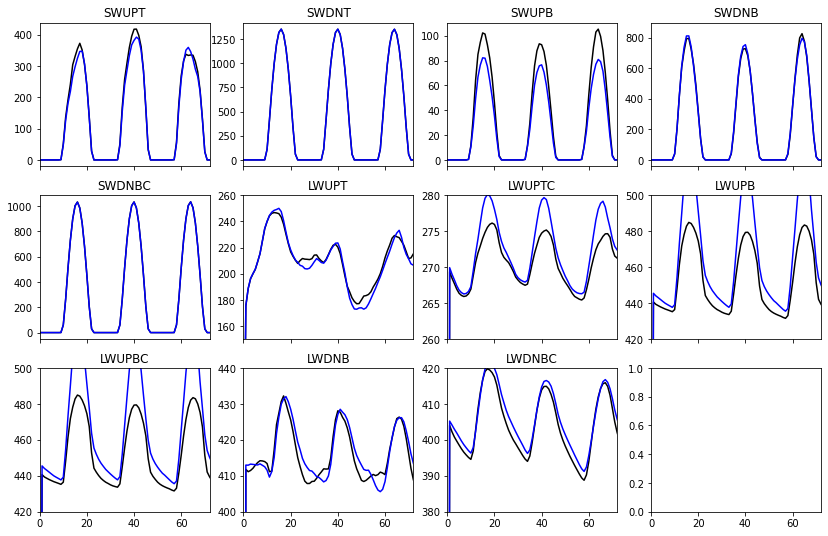

In [27]:
varname = ['SWUPT','SWDNT','SWUPB','SWDNB','SWDNBC','LWUPT','LWUPTC','LWUPB','LWUPBC','LWDNB','LWDNBC']
fig,axes= plt.subplots(3,4,figsize=(14,9),sharex=True)
axes=axes.ravel()
for ii in range(11):
    var0_IL_name = varname[ii]+'0_IL'
    var1_IL_name = varname[ii]+'1_IL'
    axes[ii].plot(globals()[var0_IL_name],'-k')
    axes[ii].plot(globals()[var1_IL_name],'-b')
    axes[ii].set_title(varname[ii])
    #ax2 = axes[ii].twinx()
    #ax2.plot(globals()[var1_IL_name]-globals()[var0_IL_name],'-r')
    axes[ii].set_xlim([0,3*24])

axes[5].set_ylim([150,260])
axes[6].set_ylim([260,280])
axes[7].set_ylim([420,500])
axes[8].set_ylim([420,500])
axes[9].set_ylim([400,440])
axes[10].set_ylim([380,420])



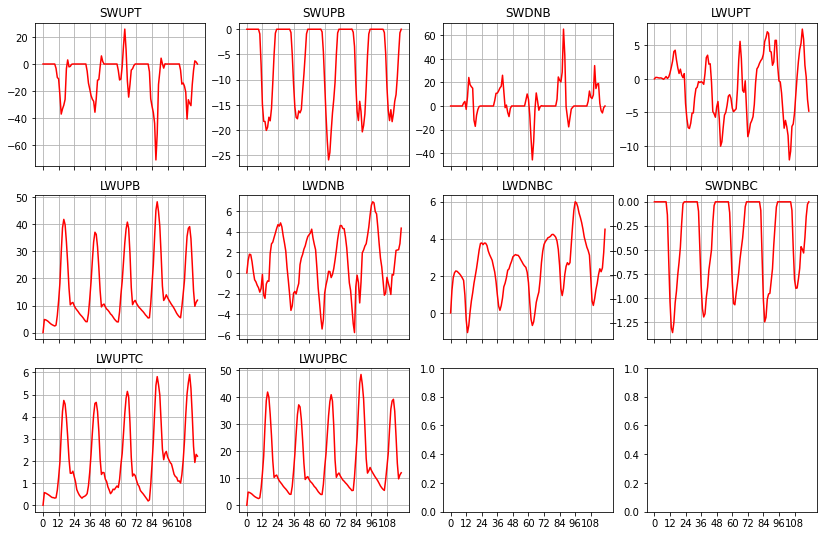

In [28]:
varname = ['SWUPT','SWUPB','SWDNB','LWUPT','LWUPB','LWDNB','LWDNBC','SWDNBC','LWUPTC','LWUPBC']
fig,axes= plt.subplots(3,4,figsize=(14,9),sharex=True)
axes=axes.ravel()
for ii in range(10):
    var0_IL_name = varname[ii]+'0_IL'
    var1_IL_name = varname[ii]+'1_IL'
    axes[ii].plot(globals()[var1_IL_name]-globals()[var0_IL_name],'-r')
    axes[ii].set_title(varname[ii])
    axes[ii].set_xticks(np.arange(0,5*24,12))
    axes[ii].grid()



### There is a nighttime warming in response to deforestation. This is mainly caused by reduction in SW reflected at TOA and reduction in outgoing LW at bottom which is mainly from clear-sky 

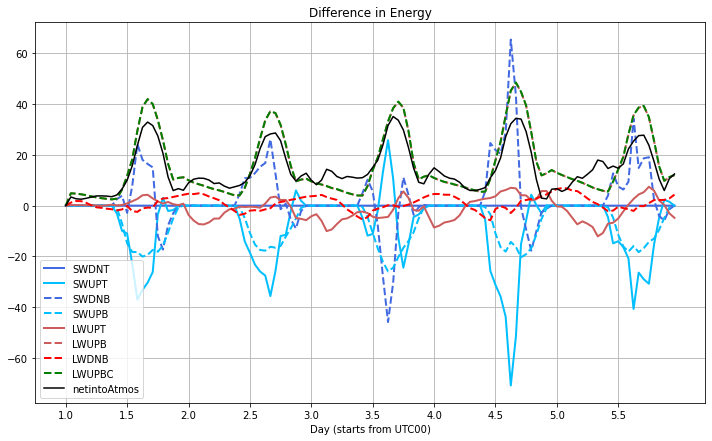

In [29]:
vars2= ['SWDNT','SWUPT','SWDNB','SWUPB','LWUPT','LWUPB','LWDNB','LWUPBC','LH','HFX']
colors=['royalblue','deepskyblue','royalblue','deepskyblue','indianred','indianred','red','green','lightgreen']
dashes=['-','-','--','--','-','--','--','--']
fig,axes= plt.subplots(1,1,figsize=(12,7),sharex=True)
for ii in range(8):
    var0_IL_name = vars2[ii]+'0_IL'
    var1_IL_name = vars2[ii]+'1_IL'
    plt.plot(globals()[var1_IL_name]-globals()[var0_IL_name],linewidth=2,
             color=colors[ii],
             linestyle=dashes[ii],
             label=vars2[ii])
plt.xticks(np.arange(0,5*24,12),np.arange(1,6,0.5))
plt.grid()
plt.title('Difference in Energy')
plt.xlabel('Day (starts from UTC00)')

### net into the atmosphere
netintoA0 = SWDNT0_IL-SWUPT0_IL-LWUPT0_IL-(SWDNB0_IL-SWUPB0_IL+LWDNB0_IL-LWUPB0_IL)
netintoA1 = SWDNT1_IL-SWUPT1_IL-LWUPT1_IL-(SWDNB1_IL-SWUPB1_IL+LWDNB1_IL-LWUPB1_IL)
plt.plot(netintoA1-netintoA0,color='k',label='netintoAtmos')

plt.legend()


### Unify the sign of each energy term. 

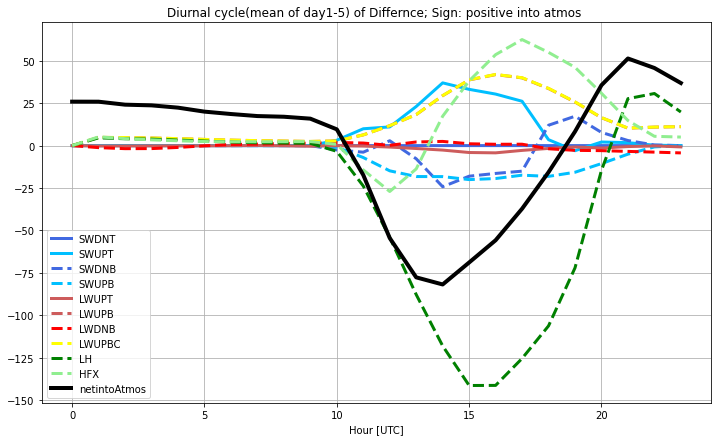

In [30]:
vars2= ['SWDNT','SWUPT','SWDNB','SWUPB','LWUPT','LWUPB','LWDNB','LWUPBC','LH','HFX']
colors=['royalblue','deepskyblue','royalblue','deepskyblue','indianred','indianred','red','yellow','green','lightgreen']
dashes=['-','-','--','--','-','--','--','--','--','--']
fig,axes= plt.subplots(1,1,figsize=(12,7),sharex=True)
for ii in range(10):
    var0_IL_name = vars2[ii]+'0_IL'
    var1_IL_name = vars2[ii]+'1_IL'
    if vars2[ii] in ['SWUPT','SWDNB','LWUPT','LWDNB']:
        tmp = globals()[var0_IL_name]-globals()[var1_IL_name]
    else:
        tmp = globals()[var1_IL_name]-globals()[var0_IL_name]
        
    #tmp_diurnal = np.reshape(tmp.values,(5,24)).mean(axis=0)
    tmp_diurnal = tmp[:24]
    
    plt.plot(tmp_diurnal,linewidth=3,
             color=colors[ii],
             linestyle=dashes[ii],
             label=vars2[ii])
#plt.xticks(np.arange(0,5*24,12),np.arange(1,6,0.5))
plt.grid()
plt.title('Diurnal cycle(mean of day1-5) of Differnce; Sign: positive into atmos ')
plt.xlabel('Hour [UTC]')

### net into the atmosphere
netintoA0 = SWDNT0_IL-SWUPT0_IL-LWUPT0_IL-(SWDNB0_IL-SWUPB0_IL+LWDNB0_IL-LWUPB0_IL)+LH0_IL+HFX0_IL
netintoA1 = SWDNT1_IL-SWUPT1_IL-LWUPT1_IL-(SWDNB1_IL-SWUPB1_IL+LWDNB1_IL-LWUPB1_IL)+LH1_IL+HFX1_IL
net_dif = netintoA1-netintoA0
plt.plot(np.reshape(net_dif.values,(5,24)).mean(axis=0),color='k',label='netintoAtmos',linewidth=4)

plt.legend()


# 3. Humidity
### clear-sky LWUP at the bottom is the reason for a daytime cooling and nighttime warming. Let's check the humidity as the clear-sky LW is related to humidity. 

Text(0, 0.5, 'Outside of IL')

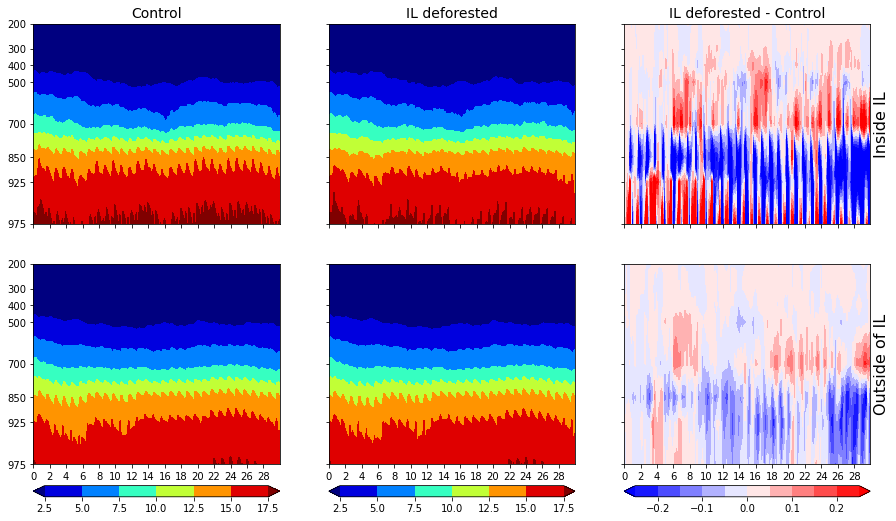

In [32]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/qvapor_IL_areaave.obs.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_IL:
    theta0_IL_areaave = ds0_IL['QVAPOR']*1000
with xarray.open_dataset(path+'post_processing/Amazon561x721/qvapor_out_areaave.obs.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds0_out:
    theta0_out_areaave = ds0_out['QVAPOR']*1000
with xarray.open_dataset(path+'post_processing/Amazon561x721/qvapor_IL_areaave.ILdeforested.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_IL:
    theta1_IL_areaave = ds1_IL['QVAPOR']*1000
with xarray.open_dataset(path+'post_processing/Amazon561x721/qvapor_out_areaave.ILdeforested.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_out:
    theta1_out_areaave = ds1_out['QVAPOR']*1000
    
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100
levs=[0,5,8,12,17,19,21,24]
pres=[975,925,850,700,500,400,300,200]
fig,axes = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
axes=axes.ravel()
im0=axes[0].contourf(np.arange(0,720),levs,theta0_IL_areaave[:,levs].transpose(),
             #levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im=axes[1].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose(),
             #levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im=axes[2].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-0.25,0.26,0.05),
            extend='both',cmap='bwr')

im=axes[3].contourf(np.arange(0,720),levs,theta0_out_areaave[:,levs].transpose(),
             #levels=np.arange(30,71,2),
            extend='both',cmap='jet')
im=axes[4].contourf(np.arange(0,720),levs,theta1_out_areaave[:,levs].transpose(),
             #levels=np.arange(30,71,2),
            extend='both',cmap='jet')

im_dif=axes[5].contourf(np.arange(0,720),levs,theta1_out_areaave[:,levs].transpose()-theta0_out_areaave[:,levs].transpose(),
             levels=np.arange(-0.25,0.26,0.05),
            extend='both',cmap='bwr')

fig.colorbar(im0,ax=axes[[0,3]],orientation='horizontal',pad=0.04)
fig.colorbar(im0,ax=axes[[1,4]],orientation='horizontal',pad=0.04)
fig.colorbar(im_dif,ax=axes[[2,5]],orientation='horizontal',pad=0.04)

for ii in [0,3]:
    axes[ii].set_yticks(levs)
    axes[ii].set_yticklabels(pres)

#axes.set_ylim([0,24])
for ii in range(3,6):
    axes[ii].set_xticks(np.arange(0,720,48))
    axes[ii].set_xticklabels(np.arange(0,30,2))

axes[0].set_title('Control',fontsize=14)
axes[1].set_title('IL deforested',fontsize=14)
axes[2].set_title('IL deforested - Control',fontsize=14)

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel('Inside IL',fontsize=16)

axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel('Outside of IL',fontsize=16)

Text(0, 0.5, 'Pressure [hPa]')

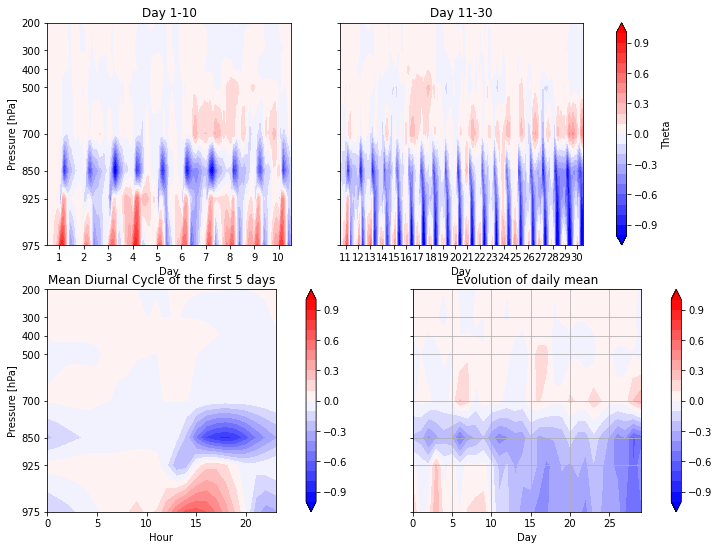

In [16]:
dif_theta = theta1_IL_areaave - theta0_IL_areaave
dif_theta_tmp = np.reshape(dif_theta.values,(30,24,34))
dif_theta_daily = dif_theta_tmp.mean(axis=1)
dif_theta_diurnal = dif_theta_tmp[:5,:,:].mean(axis=0)

fig,axes = plt.subplots(2,2,figsize=(12,9),sharey=True)
axes=axes.ravel()
axes[0].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
axes[0].set_xlim([0,10*24])

im=axes[1].contourf(np.arange(0,720),levs,theta1_IL_areaave[:,levs].transpose()-theta0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
axes[1].set_xlim([10*24,720])
fig.colorbar(im,ax=axes[:2],orientation='vertical',pad=0.05,label='Theta')

im2=axes[2].contourf(np.arange(0,24),levs,dif_theta_diurnal[:,levs].transpose(),
             levels=np.arange(-1.0,1.1,0.1),
            extend='both',cmap='bwr')
fig.colorbar(im2,ax=axes[2],orientation='vertical',pad=0.1)

im2=axes[3].contourf(np.arange(0,30),levs,dif_theta_daily[:,levs].transpose(),
                    levels=np.arange(-1,1.1,0.1),
            extend='both',cmap='bwr')
fig.colorbar(im2,ax=axes[3],orientation='vertical',pad=0.1)


titles=['Day 1-10','Day 11-30','Mean Diurnal Cycle of the first 5 days','Evolution of daily mean']
for ii in range(4):
    axes[ii].set_title(titles[ii])

axes[0].set_yticks(levs)
axes[0].set_yticklabels(pres)
axes[3].grid()

#for ii in range(2):
axes[0].set_xticks(np.arange(0+12,10*24+12,24))
axes[0].set_xticklabels(np.arange(1,11))
axes[1].set_xticks(np.arange(10*24+12,30*24+12,24))
axes[1].set_xticklabels(np.arange(11,31))
    
xlabels=['Day','Day','Hour','Day']
for ii in range(4):
    axes[ii].set_xlabel(xlabels[ii])

axes[0].set_ylabel('Pressure [hPa]')
axes[2].set_ylabel('Pressure [hPa]')

## 2. Vertically integrated water vapor

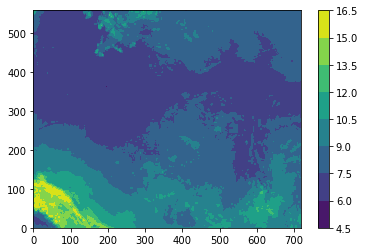

In [17]:
# calculate dp
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file0 = path+'Amazon561x721/3Dfields_d01_2015-11-30_15:00:00'
with xarray.open_dataset(file0,decode_times=False,
                         mask_and_scale='True') as ds0:
    P0=ds0['P'][:,:,:]
P0_ave = P0[0,:,200:,300:].mean(('south_north','west_east'))
plt.contourf(P0[0,10,:,:]/100)
plt.colorbar()

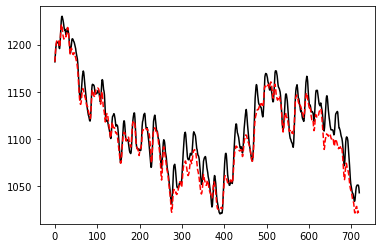

In [36]:
qdp0 = (theta0_IL_areaave[:,0:-1]+theta0_IL_areaave[:,1:])/2*(P0_ave[0:-1]-P0_ave[1:])/9.81
qint0 = qdp0.sum(axis=1)

qdp1 = (theta1_IL_areaave[:,0:-1]+theta1_IL_areaave[:,1:])/2*(P0_ave[0:-1]-P0_ave[1:])/9.81
qint1 = qdp1.sum(axis=1)

plt.plot(qint0,'-k')
plt.plot(qint1,'--r')


Text(0.5, 0, 'Day')

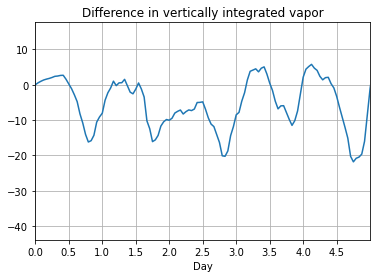

In [45]:
plt.plot(qint1-qint0)
plt.grid()
plt.xlim(0,24*5)
plt.xticks(np.arange(0,24*5,12),np.arange(0,5,0.5))
plt.title('Difference in vertically integrated vapor')
plt.xlabel('Day')

### The low-level noon atmosphere cools down and the nighttime temperature rises up when the IL was deforested. Interesting! Let's take a look at the energy. 

First, think about what determines the lower-atmosphere temperature. Is it the energy to the surface? Is it the energy to the bottom of the atmosphere? WRF has SWDOWN and GLW (energy into the ground surface). These are slightly (by < 1 W/m^2 ) lower (higher) than energy to the bottom (SWDWB and LWDNB) over the forests (Savannah)

##plt.contourf(ds0['SWDOWN'][15,:,:]-ds0['SWDNB'][15,:,:],cmap='bwr',levels=np.arange(-5,6,1))
##plt.colorbar()

#### Then, let's check the difference between Rnet(FLX+LH) and the net energy at the bottom. See below. It shows that NetB is slightly (10-12%) greater than Rnet over the forests. Let's use NetB to understand the lower-atmosphere temperature change. 

ok
ok


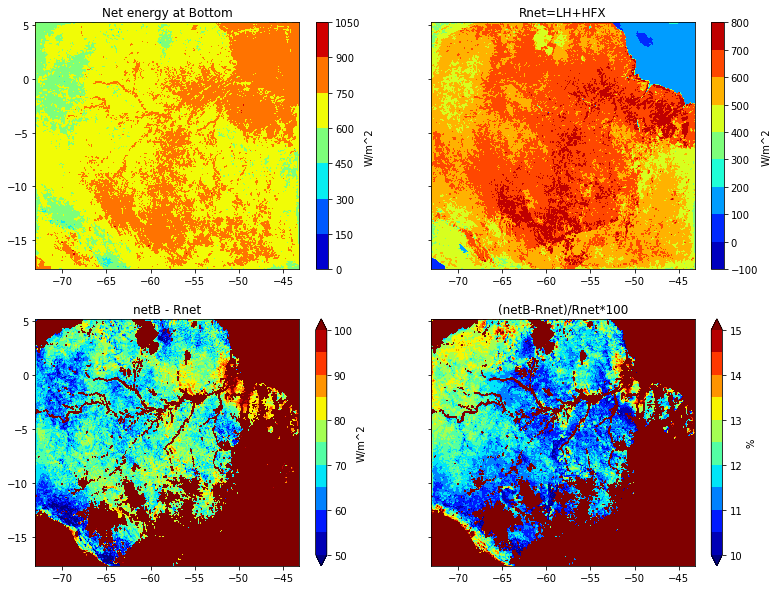

In [22]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.201511.ILdeforested.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
net_atms=ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']
Rnet = ds0['LH']+ds0['HFX']
fig,axes= plt.subplots(2,2,figsize=(13,10),sharey=True)
axes=axes.ravel()
im0=axes[0].contourf(lons,lats,net_atms[15,:,:],cmap='jet')
im1=axes[1].contourf(lons,lats,Rnet[15,:,:],cmap='jet')
fig.colorbar(im0,ax=axes[0],label='W/m^2')
fig.colorbar(im1,ax=axes[1],label='W/m^2')

im2=axes[2].contourf(lons,lats,net_atms[15,:,:] - Rnet[15,:,:],cmap='jet',
                    levels=np.arange(50,101,5),extend='both')
fig.colorbar(im2,ax=axes[2],label='W/m^2')

im3=axes[3].contourf(lons,lats,(net_atms[15,:,:] - Rnet[15,:,:])/Rnet[15,:,:]*100,cmap='jet',
                    levels=np.arange(10,15.5,.5),extend='both')
fig.colorbar(im3,ax=axes[3],label='%')

titles=['Net energy at Bottom','Rnet=LH+HFX','netB - Rnet','(netB-Rnet)/Rnet*100']
for ii in range(4):
    axes[ii].set_title(titles[ii])
    
# Figure out a way to denote the forest region. 
#for ii in range(3):
#    axes[ii].contour(lons,lats,lu0[:,:],levels=[1,10],colors='white')


Text(0.5, 1.0, 'UTC 9')

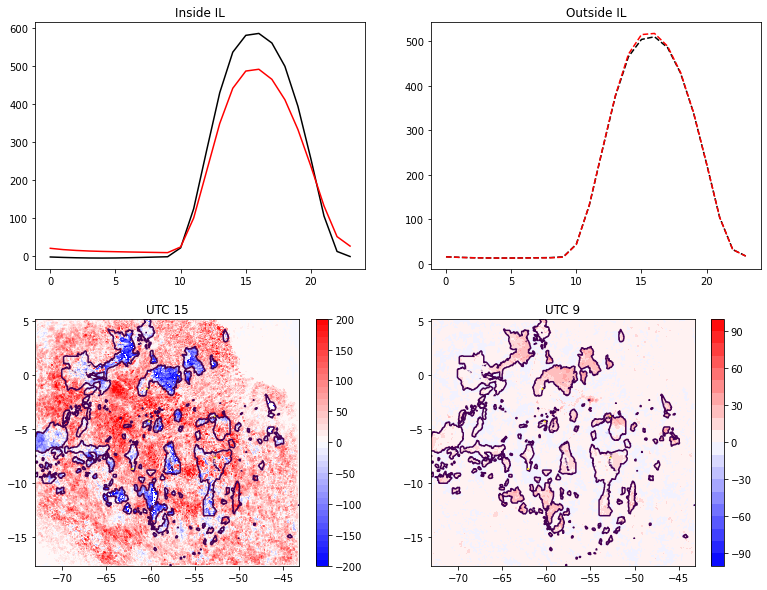

In [25]:
#netB0=ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']
#netB1=ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']-ds1['LWUPB']
netB0 = ds0['LH']+ds0['HFX']
netB1 = ds1['LH']+ds1['HFX']

dif_lu = lu1-lu0
netB0_IL = netB0.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
netB0_out = netB0.where(dif_lu==0,np.nan).mean(('south_north','west_east'))
netB1_IL = netB1.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
netB1_out = netB1.where(dif_lu==0,np.nan).mean(('south_north','west_east'))

fig,axes= plt.subplots(2,2,figsize=(13,10))
axes=axes.ravel()
axes[0].plot(netB0_IL,'-k')
axes[0].plot(netB1_IL,'-r')
axes[1].plot(netB0_out,'--k')
axes[1].plot(netB1_out,'--r')
axes[0].set_title('Inside IL')
axes[1].set_title('Outside IL')
im0=axes[2].contourf(lons,lats,netB1[15,:,:]-netB0[15,:,:],cmap='bwr',levels=np.arange(-200,201,10))
im1=axes[3].contourf(lons,lats,netB1[9,:,:]-netB0[9,:,:],cmap='bwr',levels=np.arange(-100,101,10))
fig.colorbar(im0,ax=axes[2])
fig.colorbar(im1,ax=axes[3])
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[3].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[2].set_title('UTC 15')
axes[3].set_title('UTC 9')


Text(0.5, 1.0, 'Net energy at Bottom; at UTC 9')

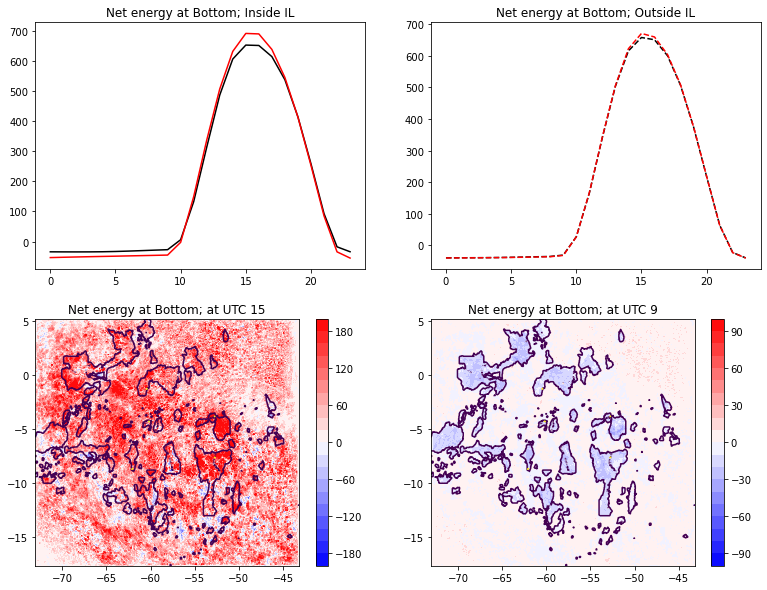

In [63]:
netB0=ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']
netB1=ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']-ds1['LWUPB']

dif_lu = lu1-lu0
netB0_IL = netB0.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
netB0_out = netB0.where(dif_lu==0,np.nan).mean(('south_north','west_east'))
netB1_IL = netB1.where(dif_lu>0,np.nan).mean(('south_north','west_east'))
netB1_out = netB1.where(dif_lu==0,np.nan).mean(('south_north','west_east'))

fig,axes= plt.subplots(2,2,figsize=(13,10))
axes=axes.ravel()
axes[0].plot(netB0_IL,'-k')
axes[0].plot(netB1_IL,'-r')
axes[1].plot(netB0_out,'--k')
axes[1].plot(netB1_out,'--r')
axes[0].set_title('Net energy at Bottom; Inside IL')
axes[1].set_title('Net energy at Bottom; Outside IL')
im0=axes[2].contourf(lons,lats,netB1[15,:,:]-netB0[15,:,:],cmap='bwr',levels=np.arange(-200,201,20))
im1=axes[3].contourf(lons,lats,netB1[9,:,:]-netB0[9,:,:],cmap='bwr',levels=np.arange(-100,101,10))
fig.colorbar(im0,ax=axes[2])
fig.colorbar(im1,ax=axes[3])
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[3].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[2].set_title('Net energy at Bottom; at UTC 15')
axes[3].set_title('Net energy at Bottom; at UTC 9')

### Ok, let's use Rnet and focus on local noon change for now. 

In [ ]:
TIME=5 ### Select local noon

path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/post_processing/Amazon561x721/'
file = path+'energy.201511.ILdeforested.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  

varname = ['LH','HFX','PBLH','TSK','ALBEDO']
levs = [np.arange(-200,201,20),np.arange(-200,201,20),np.arange(-200,201,20),np.arange(-3,3.1,0.3),
        np.arange(-0.1,0.11,0.01)]
for ii in range(5):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][TIME,:,:]-ds0[varname[ii]][TIME,:,:],cmap='bwr',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].contourf(lons,lats,Rnet1[TIME,:,:]-Rnet0[TIME,:,:],
                       levels = np.arange(-200,201,20),extend='both',cmap='bwr')
fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

### Plot SWdown at bottom which directly related to albedo. 

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

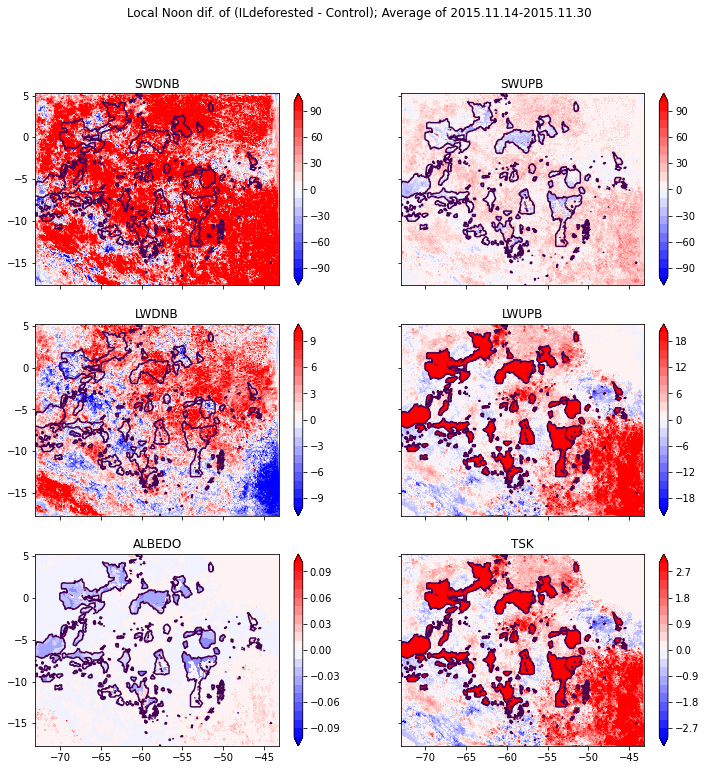

In [33]:
TIME=15 ### Select local noon
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.2015.ILgrassland.multidaymean.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  

varname = ['SWDNB','SWUPB','LWDNB','LWUPB','ALBEDO','TSK']
levs = [np.arange(-100,101,10),np.arange(-100,101,10),np.arange(-10,11,1),np.arange(-20,21,2),
        np.arange(-0.1,0.11,0.01),np.arange(-3,3.1,0.3)]
for ii in range(6):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][TIME,:,:]-ds0[varname[ii]][TIME,:,:],cmap='bwr',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

### Plot the T2m or TH2m change to check whether it is consistent with HFX change and LWDNB change. 

In [46]:
### read in the multi-noon files of 3Dfields*.nc and then take the average. 
fname = path+'Amazon561x721/3Dfields_d01_2015-11-??_15:00:00'
files = glob.glob(fname)
files.sort()
with xarray.open_dataset(files[15],decode_times=False,
                         mask_and_scale='True') as ds0:
     T2m_0= ds0['Q2']*1000

for file in files[16:30]:
    with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_other:
         T2m_0= xarray.concat([T2m_0,ds0_other['Q2']*1000],dim='Time')
del files
            
fname = path+'Amazon561x721_ILdeforested/3Dfields_d01_2015-11-??_15:00:00'
files = glob.glob(fname)
files.sort()
with xarray.open_dataset(files[15],decode_times=False,
                         mask_and_scale='True') as ds1:
     T2m_1= ds1['Q2']*1000

for file in files[16:30]:
    with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_other:
         T2m_1= xarray.concat([T2m_1,ds1_other['Q2']*1000],dim='Time')

Text(0.5, 1.0, 'Change in Q2m')

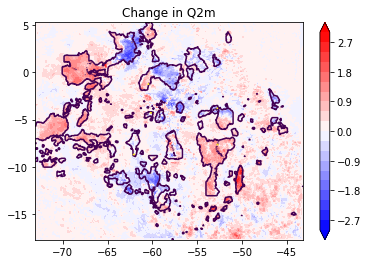

In [48]:
plt.contourf(lons,lats,T2m_1.mean(axis=0)-T2m_0.mean(axis=0),
            levels=np.arange(-3,3.1,0.3),
            extend='both',cmap='bwr')
plt.colorbar()
plt.contour(lons,lats,lu1-lu0,levels=[1,10])
plt.title('Change in Q2m')

### TOA energy

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

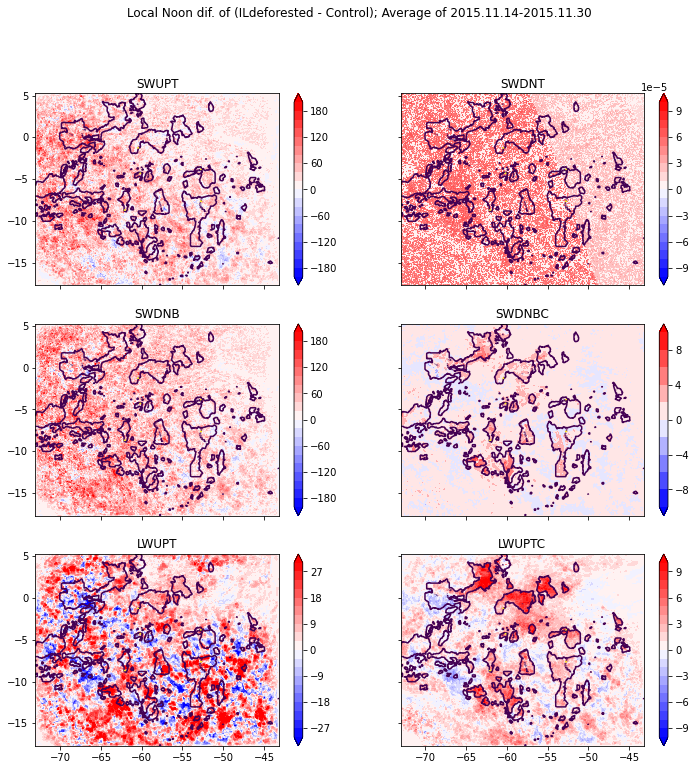

In [46]:
TIME=20 ### Select local noon
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.201511.ILdeforested.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  

varname = ['SWUPT','SWDNT','SWDNB','SWDNBC','LWUPT','LWUPTC']
levs = [np.arange(-200,201,20),np.arange(-1,1.1,0.1)*1e-4,np.arange(-200,201,20),np.arange(-10,11,2),
        np.arange(-30,31,3),np.arange(-10,11,1)]
for ii in range(6):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][TIME,:,:]-ds0[varname[ii]][TIME,:,:],cmap='bwr',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

### Animation

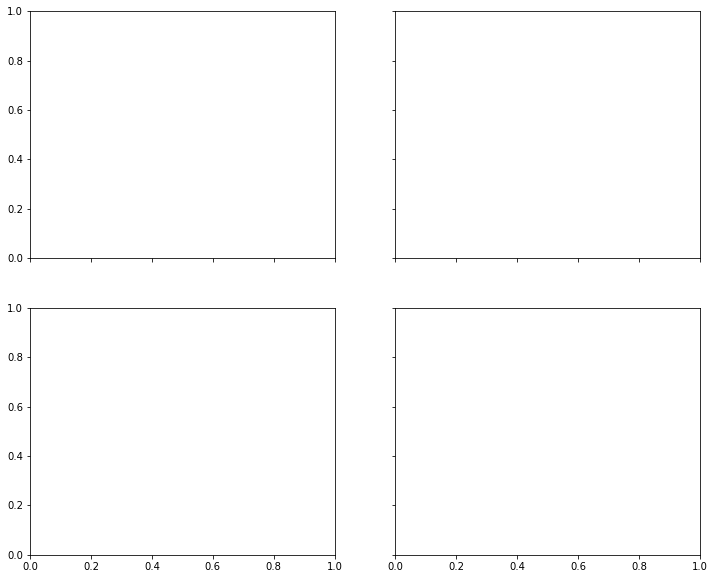

In [42]:
fig,axes = plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)
ax = axes.ravel() 

def animate(ii):
        
    im0=ax[0].contourf(lons,lats,ds1['SWUPT'][8+ii,:,:]-ds0['SWUPT'][ii,:,:],cmap='bwr',
                    levels=np.arange(-200,201,20),
                    extend='both')
    im1=ax[1].contourf(lons,lats,ds1['SWDNT'][8+ii,:,:]-ds0['SWDNT'][ii,:,:],cmap='bwr',
                    levels=np.arange(-1,1.1,0.1)*1e-4,
                    extend='both')
    im0=ax[2].contourf(lons,lats,ds1['LWUPT'][8+ii,:,:]-ds0['SWUPT'][ii,:,:],cmap='bwr',
                    levels=np.arange(-30,31,3),
                    extend='both')
    im1=ax[3].contourf(lons,lats,ds1['LWUPTC'][8+ii,:,:]-ds0['SWDNT'][ii,:,:],cmap='bwr',
                    levels=np.arange(-10,11,1),
                    extend='both')
    ax[0].set_title('Hour = '+str(8+ii)+'UTC')

    #fig.colorbar(im0,ax=ax[0])
    #fig.colorbar(im1,ax=ax[1])

anim = FuncAnimation(fig, animate, interval=1,frames=16)
plt.show()
anim.save('SW.gif', writer='imagemagick',fps=1)

### The albedo change is not consistent with the simple expectation regarding the impact of deforestation. I guess the clouds might have changed as well. Let's take a look. 

### Map animation of vertically integrated Cp*T*dp (total column dry static energy) difference between the sims, for the first few simulated days. I think we should be able to see this nocturnal heat pool accumulate and spread more directly than with the PBLH proxy, and better assess if it is competing with a counteracting daytime effect, by looking across a few diurnal cycles.

## 1. Plot the cloud fraction

### 1.1 height-time cross-section of the area-average

In [10]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/cldfrac_IL_areaave.obs.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_IL:
    cld0_IL_areaave = ds0_IL['CLDFRA']
with xarray.open_dataset(path+'post_processing/Amazon561x721/cldfrac_out_areaave.obs.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds0_out:
    cld0_out_areaave = ds0_out['CLDFRA']
with xarray.open_dataset(path+'post_processing/Amazon561x721/cldfrac_IL_areaave.ILdeforested.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_IL:
    cld1_IL_areaave = ds1_IL['CLDFRA']
with xarray.open_dataset(path+'post_processing/Amazon561x721/cldfrac_out_areaave.ILdeforested.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_out:
    cld1_out_areaave = ds1_out['CLDFRA']

Text(0, 0.5, 'Outside of IL')

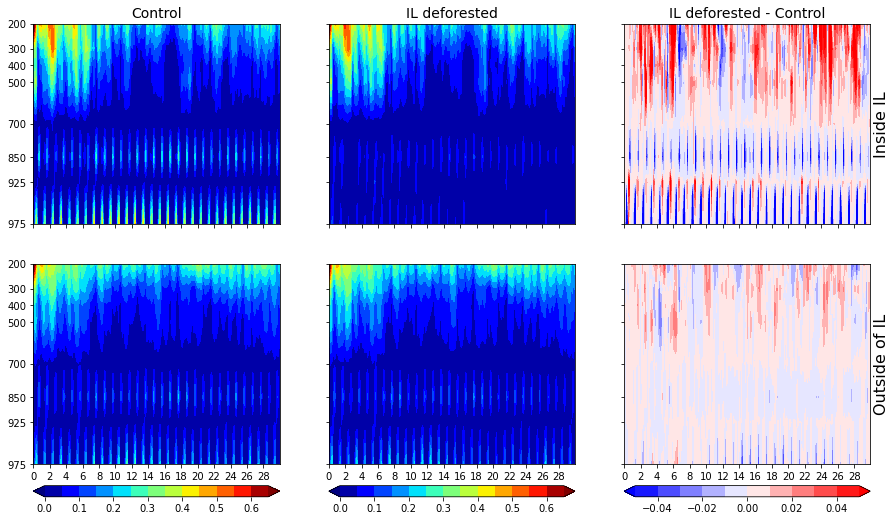

In [14]:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100
levs=[0,5,8,12,17,19,21,24]
pres=[975,925,850,700,500,400,300,200]
fig,axes = plt.subplots(2,3,figsize=(15,10),sharex=True,sharey=True)
axes=axes.ravel()
im0=axes[0].contourf(np.arange(0,720),levs,cld0_IL_areaave[:,levs].transpose(),
             levels=np.arange(0,0.7,0.05),
            extend='both',cmap='jet')

im=axes[1].contourf(np.arange(0,720),levs,cld1_IL_areaave[:,levs].transpose(),
             levels=np.arange(0,0.7,0.05),
            extend='both',cmap='jet')

im=axes[2].contourf(np.arange(0,720),levs,cld1_IL_areaave[:,levs].transpose()-cld0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-0.05,0.06,0.01),
            extend='both',cmap='bwr')

im=axes[3].contourf(np.arange(0,720),levs,cld0_out_areaave[:,levs].transpose(),
             levels=np.arange(0,0.7,0.05),
            extend='both',cmap='jet')
im=axes[4].contourf(np.arange(0,720),levs,cld1_out_areaave[:,levs].transpose(),
             levels=np.arange(0,0.7,0.05),
            extend='both',cmap='jet')

im_dif=axes[5].contourf(np.arange(0,720),levs,cld1_out_areaave[:,levs].transpose()-cld0_out_areaave[:,levs].transpose(),
             levels=np.arange(-0.05,0.06,0.01),
            extend='both',cmap='bwr')

fig.colorbar(im,ax=axes[[0,3]],orientation='horizontal',pad=0.04)
fig.colorbar(im,ax=axes[[1,4]],orientation='horizontal',pad=0.04)
fig.colorbar(im_dif,ax=axes[[2,5]],orientation='horizontal',pad=0.04)

for ii in [0,3]:
    axes[ii].set_yticks(levs)
    axes[ii].set_yticklabels(pres)

#axes.set_ylim([0,24])
for ii in range(3,6):
    axes[ii].set_xticks(np.arange(0,720,48))
    axes[ii].set_xticklabels(np.arange(0,30,2))

axes[0].set_title('Control',fontsize=14)
axes[1].set_title('IL deforested',fontsize=14)
axes[2].set_title('IL deforested - Control',fontsize=14)

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel('Inside IL',fontsize=16)

axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel('Outside of IL',fontsize=16)

### Plot the diurnal cycle of the height-time cross-section of clouds.

[Text(0, 0, '975'),
 Text(0, 5, '925'),
 Text(0, 8, '850'),
 Text(0, 12, '700'),
 Text(0, 17, '500'),
 Text(0, 19, '400'),
 Text(0, 21, '300'),
 Text(0, 24, '200')]

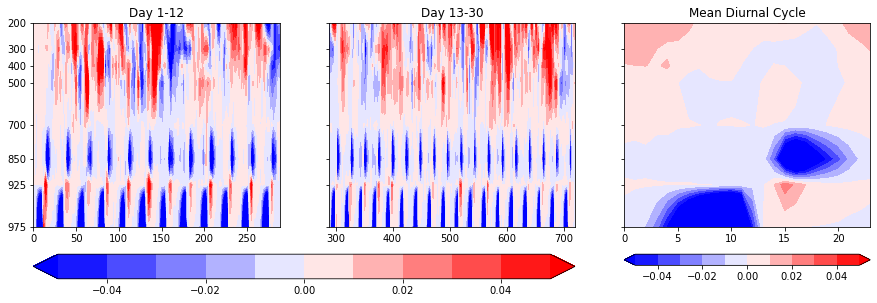

In [16]:
dif_cld = cld1_IL_areaave - cld0_IL_areaave
dif_cld_diurnal = np.reshape(dif_cld.values,(30,24,34)).mean(axis=0)

fig,axes = plt.subplots(1,3,figsize=(15,5),sharey=True)
axes=axes.ravel()
axes[0].contourf(np.arange(0,720),levs,cld1_IL_areaave[:,levs].transpose()-cld0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-0.05,0.06,0.01),
            extend='both',cmap='bwr')
axes[0].set_xlim([0,12*24])

im=axes[1].contourf(np.arange(0,720),levs,cld1_IL_areaave[:,levs].transpose()-cld0_IL_areaave[:,levs].transpose(),
             levels=np.arange(-0.05,0.06,0.01),
            extend='both',cmap='bwr')
axes[1].set_xlim([12*24,720])
fig.colorbar(im,ax=axes[:2],orientation='horizontal',pad=0.1)

im2=axes[2].contourf(np.arange(0,24),levs,dif_cld_diurnal[:,levs].transpose(),
             levels=np.arange(-0.05,0.06,0.01),
            extend='both',cmap='bwr')
fig.colorbar(im2,ax=axes[2],orientation='horizontal',pad=0.1)

titles=['Day 1-12','Day 13-30','Mean Diurnal Cycle']
for ii in range(3):
    axes[ii].set_title(titles[ii])

axes[0].set_yticks(levs)
axes[0].set_yticklabels(pres)

### 1.2 horizontal map [925mb, 850mb, 300mb] of the multiday-mean

In [4]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/cloudfrac.201511UTC15.obs.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_cld:
    print('ok')
cld0_noonmean=ds0_cld['CLDFRA'][0,:,:,:]

with xarray.open_dataset(path+'post_processing/Amazon561x721/cloudfrac.201511UTC15.ILdeforested.nc',
                         decode_times=False,
                         mask_and_scale='True') as ds1_cld:
    print('ok')
cld1_noonmean=ds1_cld['CLDFRA'][0,:,:,:]

ok
ok


Text(0, 0.5, '300mb')

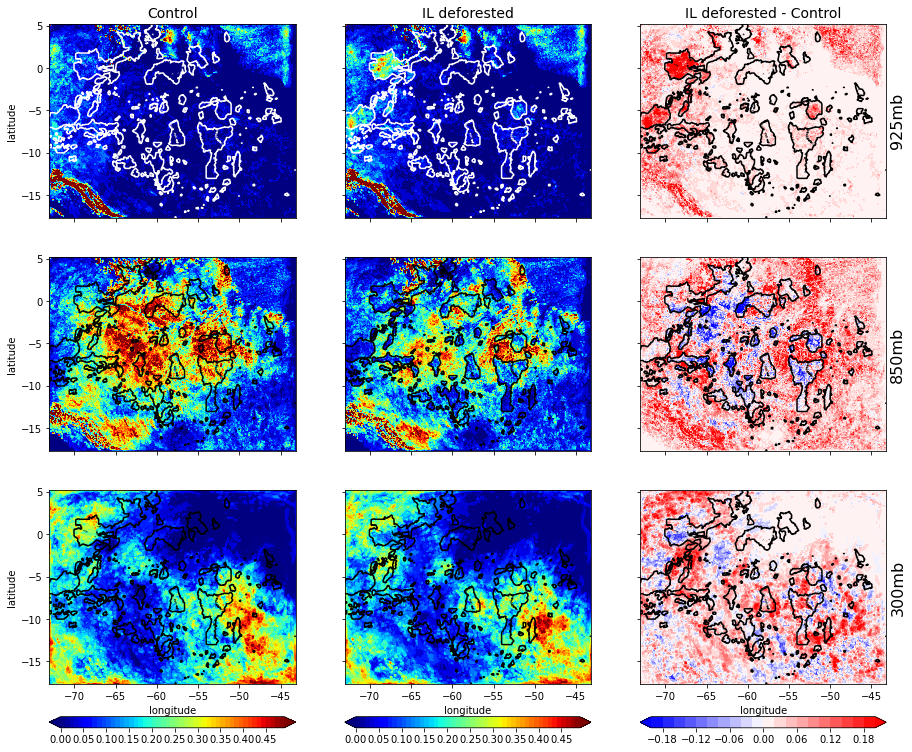

In [9]:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100
levs=[0,5,8,12,17,19,21,24]
pres=[975,925,850,700,500,400,300,200]
fig,axes = plt.subplots(3,3,figsize=(15,15),sharex=True,sharey=True)
axes=axes.ravel()

for ii,lev in enumerate([5,8,21]):
    im0=axes[ii*3].contourf(lons,lats,cld0_noonmean[lev,:,:],
             levels=np.arange(0,0.5,0.01),
            extend='both',cmap='jet')

    im=axes[ii*3+1].contourf(lons,lats,cld1_noonmean[lev,:,:],
             levels=np.arange(0,0.5,0.01),
            extend='both',cmap='jet')

    im_dif=axes[ii*3+2].contourf(lons,lats,cld1_noonmean[lev,:,:] - cld0_noonmean[lev,:,:],
             levels=np.arange(-0.2,0.21,0.02),
            extend='both',cmap='bwr')

fig.colorbar(im0,ax=axes[[0,3,6]],orientation='horizontal',pad=0.04)
fig.colorbar(im0,ax=axes[[1,4,7]],orientation='horizontal',pad=0.04)
fig.colorbar(im_dif,ax=axes[[2,5,8]],orientation='horizontal',pad=0.04)

for ii in range(2,9):
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10],colors='black')
for ii in range(2):
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10],colors='white')


for ii in [0,3,6]:
    axes[ii].set_ylabel('latitude')

for ii in range(6,9):
    axes[ii].set_xlabel('longitude')
    #axes[ii].set_xticklabels(np.arange(0,30,2))

axes[0].set_title('Control',fontsize=14)
axes[1].set_title('IL deforested',fontsize=14)
axes[2].set_title('IL deforested - Control',fontsize=14)

axes[2].yaxis.set_label_position("right")
axes[2].set_ylabel('925mb',fontsize=16)

axes[5].yaxis.set_label_position("right")
axes[5].set_ylabel('850mb',fontsize=16)

axes[8].yaxis.set_label_position("right")
axes[8].set_ylabel('300mb',fontsize=16)

### plot the LH, SH, Rnet, TSK

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

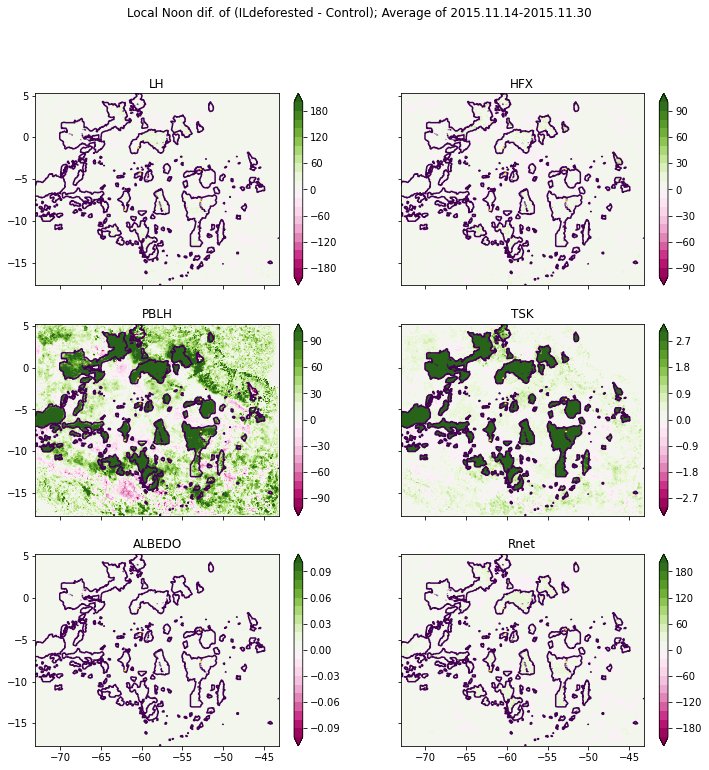

In [7]:
TIME=3 ### Select local noon
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'post_processing/Amazon561x721/energy.201511.ILdeforested.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','PBLH','TSK','ALBEDO']
levs = [np.arange(-200,201,20),np.arange(-100,101,10),np.arange(-100,101,10),np.arange(-3,3.1,0.3),
        np.arange(-0.1,0.11,0.01)]
for ii in range(5):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][TIME,:,:]-ds0[varname[ii]][TIME,:,:],cmap='PiYG',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].contourf(lons,lats,Rnet1[TIME,:,:]-Rnet0[TIME,:,:],
                       levels = np.arange(-200,201,20),extend='both',cmap='PiYG')
fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

## A specific day of change

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

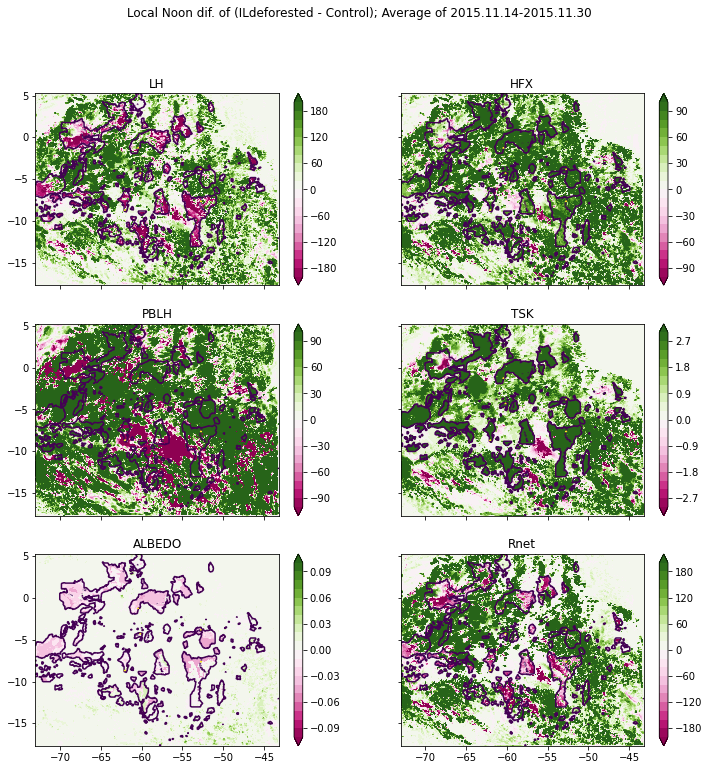

In [6]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILgrassland/energyflux_d01_2015-11-21_15:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

file = path+'Amazon561x721/energyflux_d01_2015-11-21_15:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  

varname = ['LH','HFX','PBLH','TSK','ALBEDO']
levs = [np.arange(-200,201,20),np.arange(-100,101,10),np.arange(-100,101,10),np.arange(-3,3.1,0.3),
        np.arange(-0.1,0.11,0.01)]
for ii in range(5):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][0,:,:]-ds0[varname[ii]][0,:,:],cmap='PiYG',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].contourf(lons,lats,Rnet1[0,:,:]-Rnet0[0,:,:],
                       levels = np.arange(-200,201,20),extend='both',cmap='PiYG')
fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

ok
ok


Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

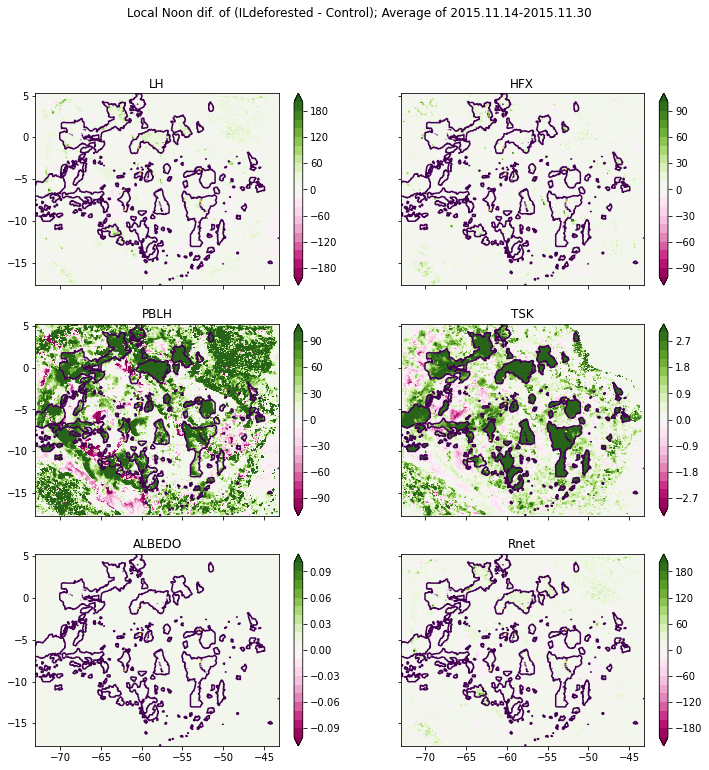

In [52]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILdeforested/energyflux_d01_2015-11-11_04:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

file = path+'Amazon561x721/energyflux_d01_2015-11-11_04:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  

varname = ['LH','HFX','PBLH','TSK','ALBEDO']
levs = [np.arange(-200,201,20),np.arange(-100,101,10),np.arange(-100,101,10),np.arange(-3,3.1,0.3),
        np.arange(-0.1,0.11,0.01)]
for ii in range(5):
    img = axes[ii].contourf(lons,lats,ds1[varname[ii]][0,:,:]-ds0[varname[ii]][0,:,:],cmap='PiYG',
                    levels=levs[ii],
                    extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].contourf(lons,lats,Rnet1[0,:,:]-Rnet0[0,:,:],
                       levels = np.arange(-200,201,20),extend='both',cmap='PiYG')
fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

## TSK, emission T, air T, night time vs day time, clouds, Rnet, equilibrium

### Plot the rainfall data

ok
ok


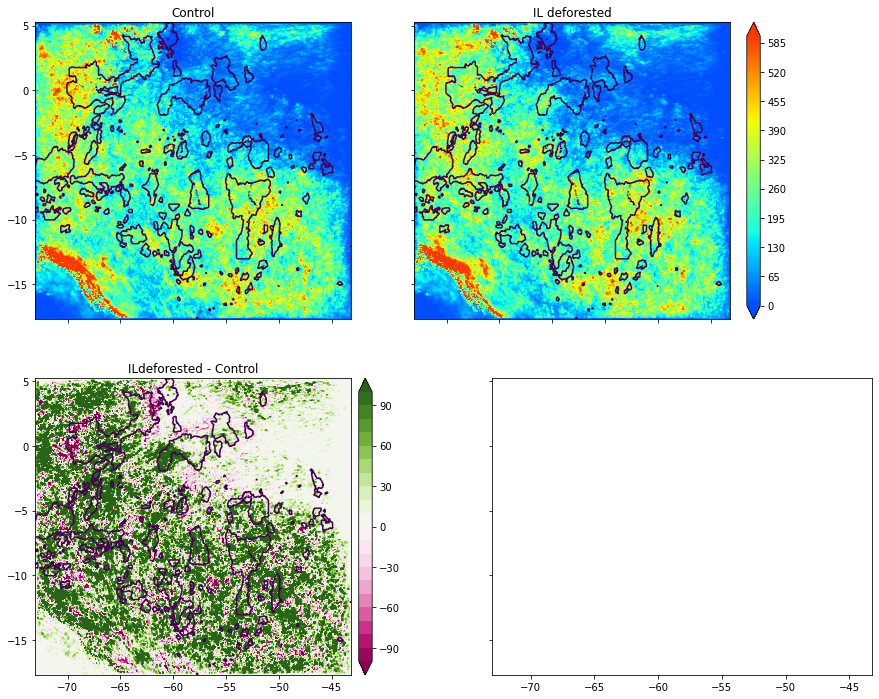

In [41]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon561x721_ILdeforested/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_rain:
    print('ok')

file = path+'Amazon561x721/energyflux_d01_2015-11-30_23:00:00'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds0_rain:
    print('ok')

### plot the figure
fig,axes = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
axes = axes.ravel()  

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.2, 0.85, 100))
newjet_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)

img=axes[0].contourf(lons,lats,ds0_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                    extend='both')
axes[1].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:],levels=np.arange(0,601,5),cmap=newjet_cmap,
                extend='both')
axes[1].contour(lons,lats,lu1-lu0,levels=[1,10])
axes[0].contour(lons,lats,lu1-lu0,levels=[1,10])

fig.colorbar(img, ax=axes[0:2],location='right',pad=0.02)
axes[0].set_title('Control')
axes[1].set_title('IL deforested')

img2=axes[2].contourf(lons,lats,ds1_rain['RAINNC'][0,:,:]-ds0_rain['RAINNC'][0,:,:],
                      levels = np.arange(-100,101,10),cmap='PiYG',extend='both')
fig.colorbar(img2, ax=axes[2],location='right',pad=0.02)
axes[2].set_title('ILdeforested - Control')
axes[2].contour(lons,lats,lu1-lu0,levels=[1,10])


### Cloud fraction

ok
ok


Text(0.5, 1.0, 'ILdeforested - Control')

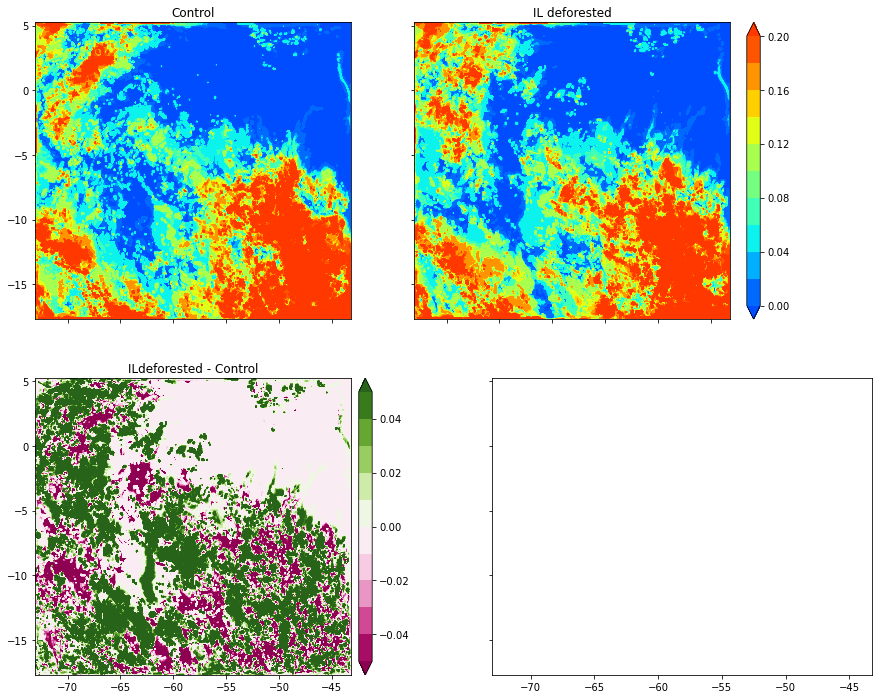

In [42]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/post_processing/Amazon561x721/'
file = path+'cloudfrac.2015.ILdeforested.nc'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1_cld:
    print('ok')

with xarray.open_dataset(path+'cloudfrac.2015.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0_cld:
    print('ok')
    
### plot the figure
fig,axes = plt.subplots(2,2,figsize=(15,12),sharex=True,sharey=True)
axes = axes.ravel()  

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.2, 0.85, 100))
newjet_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)

img=axes[0].contourf(lons,lats,ds0_cld['CLDFRA'][0,20,:,:],cmap=newjet_cmap,
                     levels=np.arange(0,0.21,0.02),
                    extend='both')
axes[1].contourf(lons,lats,ds1_cld['CLDFRA'][0,20,:,:],cmap=newjet_cmap,
                    levels=np.arange(0,0.21,0.02),
                extend='both')
fig.colorbar(img, ax=axes[0:2],location='right',pad=0.02)
axes[0].set_title('Control')
axes[1].set_title('IL deforested')

img2=axes[2].contourf(lons,lats,ds1_cld['CLDFRA'][0,20,:,:]-ds0_cld['CLDFRA'][0,20,:,:],
                                           levels=np.arange(-.05,0.051,0.01),
                      cmap='PiYG',extend='both')
fig.colorbar(img2, ax=axes[2],location='right',pad=0.02)
axes[2].set_title('ILdeforested - Control')

### Plot the original LH data

Text(0.5, 1.0, 'IL deforested')

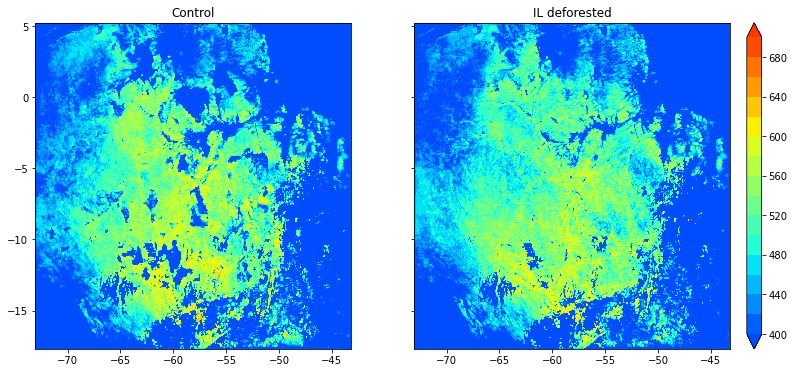

In [9]:
fig,axes = plt.subplots(1,2,figsize=(15,6),sharex=True,sharey=True)
axes = axes.ravel()  

cmap = plt.get_cmap('jet')
colors = cmap(np.linspace(0.2, 0.85, 100))
newjet_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)

img=axes[0].contourf(lons,lats,ds0['LH'][15,:,:],levels=np.arange(400,701,20),cmap=newjet_cmap,
                    extend='both')
axes[1].contourf(lons,lats,ds1['LH'][15,:,:],levels=np.arange(400,701,20),cmap=newjet_cmap,
                extend='both')
fig.colorbar(img, ax=axes,location='right',pad=0.02)
axes[0].set_title('Control')
axes[1].set_title('IL deforested')